# Tutorial: Differential Centrifugation Workflow 

*grassp* is a python package that facilitates the analysis of subcellular proteomics data (with an emphasis on graph-based analyses).  
In this tutorial we analyze subcellular proteomics data produced by differential ultracentrifugation (DC). 


In [1]:
# Spatial and single cell analysis
import grassp as gr
import scanpy as sc

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Numerical computing and statistics
import numpy as np

/Users/duo.peng/miniforge3/envs/grassp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading files

We'll load the count matrix into an AnnData object, a data structure that provides multiple compartments for storing annotations and various data representations.  
For a comprehensive AnnData tutorial, refer to the [Getting Started with AnnData](https://anndata.readthedocs.io/en/stable/tutorials/notebooks/getting-started.html) guide.


In [2]:
# Grassp provides methods to read from common proteomics formats in the io module.
# Here we read a MaxQuant output file.
dc = gr.io.read_maxquant(
    "https://public.czbiohub.org/proteinxlocation/internal/proteinGroups.txt",
    intensity_column_prefixes=["LFQ intensity ", "MS/MS count "],
)

dc.var["subcellular_enrichment"] = dc.var_names.str.split("_").str[-1]
dc.var["subcellular_enrichment"] = dc.var["subcellular_enrichment"].replace(
    "cyt", "Cyt"
)

dc.var["biological_replicate"] = dc.var_names.str.split("_").str[0].str[-1]

The centrifugation data in this tutorial comes from Leonetti and Elias labs at CZ Biohub SF (unpublished).  
Centrifugation-based subcellular fractionation experiments separate cellular components by spinning samples at increasing speeds (1K, 3K, 5K, 12K, 24K, 80K × g) to partition organelles and subcellular structures based on their density and size, with the cytoplasmic fraction (Cyt) representing the final supernatant. 

This approach differs from immunoprecipitation (IP) pull-downs, which use antibodies to specifically capture target proteins and their interacting partners.

Although we are loading in the data from our online data repository, grassp comes with several example datasets.  
The commented-out lines below shows how to load in these data, including arguments specifying raw or enriched data. 

In [3]:
# example_load_raw = gr.datasets.hek_dc_2025(enrichment="raw")
# example_load_enr = gr.datasets.hek_dc_2025(enrichment="enriched")

In [4]:
# print information about the loaded dataset
dc

AnnData object with n_obs × n_vars = 10224 × 42
    obs: 'Protein IDs', 'Majority protein IDs', 'Peptide counts (all)', 'Peptide counts (razor+unique)', 'Peptide counts (unique)', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Q-value', 'Score', 'Intensity', 'iBAQ', 'MS/MS count', 'Only identified by site', 'Reverse', 'Potential contaminant', 'id', 'Peptide IDs', 'Peptide is razor', 'Mod. peptide IDs', 'Evidence IDs', 'MS/MS IDs', 'Best MS/MS', 'Oxidation (M) site IDs', 'Oxidation (M) site positions'
    var: 'subcellular_enrichment', 'biological_replicate'
    uns: 'RawInfo'
    layers: 'MS_MS count'

Let's go through the information printed above:

`n_obs` is the number of observations (i.e. proteins in this tutorial)  
`n_var` is the number of variables (i.e. spin-fractions/pulldowns in this tutorial)  
please note in single-cell RNA-seq datasets, observations correspond to individual cells, and variables correspond to genes (or transcripts)
> AnnData object with n_obs × n_vars = 10224 × 42

Under `obs` we find the metadata for the proteins. Each entry is a column in a pandas DataFrame.
>    obs: 'Protein IDs', 'Majority protein IDs', 'Peptide counts (all)', 'Peptide counts (razor+unique)', 'Peptide counts (unique)', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Q-value', 'Score', 'Intensity', 'iBAQ', 'MS/MS count', 'Only identified by site', 'Reverse', 'Potential contaminant', 'id', 'Peptide IDs', 'Peptide is razor', 'Mod. peptide IDs', 'Evidence IDs', 'MS/MS IDs', 'Best MS/MS', 'Oxidation (M) site IDs', 'Oxidation (M) site positions'

Under `var` we find the metadata for the pulldowns/Fractions.
>   var: 'subcellular_enrichment', 'biological_replicate'

## Preprocessing

### Adding Compartment Annotations
We add annotations that specify the ground truth subcellular compartments for each protein.

In [5]:
gr.pp.add_markers(dc, species="hsap")
dc.obs[20:30]

Added lilley annotations for 333/10224 proteins (3.3%)
Added christopher annotations for 658/10224 proteins (6.4%)
Added geladaki annotations for 277/10224 proteins (2.7%)
Added itzhak annotations for 429/10224 proteins (4.2%)
Added villaneuva annotations for 289/10224 proteins (2.8%)
Added hein2024_component annotations for 2682/10224 proteins (26.2%)
Added hein2024_gt_component annotations for 861/10224 proteins (8.4%)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,lilley,christopher,geladaki,itzhak,villaneuva,hein2024_component,hein2024_gt_component
Protein IDs,,,,,,,,,,,,,,,,,,,,,
A0PJZ3,A0PJZ3,A0PJZ3,12,11,11,Glucoside xylosyltransferase 2,GXYLT2,sp|A0PJZ3|GXLT2_HUMAN Glucoside xylosyltransfe...,1,12,...,290891;954684;1520287;1944587;2052554;2092776;...,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0PK00,A0PK00,A0PK00,7,7,6,Transmembrane protein 120B,TMEM120B,sp|A0PK00|T120B_HUMAN Transmembrane protein 12...,1,7,...,510586;1024797;1312008;1406670;1439697;2639237...,nan,nan,NaN,NaN,NaN,NaN,NaN,ER,NaN
A1A4S6,A1A4S6,A1A4S6,15,15,14,Rho GTPase-activating protein 10,ARHGAP10,sp|A1A4S6|RHG10_HUMAN Rho GTPase-activating pr...,1,15,...,180930;1021195;1233806;1268946;1463178;1550564...,nan,nan,NaN,NaN,NaN,NaN,NaN,Recycling endosome,NaN
A1A5B4-3;A1A5B4,A1A5B4-3;A1A5B4,A1A5B4-3;A1A5B4,1;1,1;1,1;1,Anoctamin-9,ANO9,sp|A1A5B4-3|ANO9_HUMAN Isoform 3 of Anoctamin-...,2,1,...,3269234,14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1A5C7;A1A5C7-4;A1A5C7-3;A1A5C7-2,A1A5C7;A1A5C7-4;A1A5C7-3;A1A5C7-2,A1A5C7;A1A5C7-4,3;2;1;1,3;2;1;1,3;2;1;1,Solute carrier family 22 member 23,SLC22A23,sp|A1A5C7|S22AN_HUMAN Solute carrier family 22...,4,3,...,941952;946688;1906576,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1KXE4-2;A1KXE4,A1KXE4-2;A1KXE4,A1KXE4-2;A1KXE4,2;2,2;2,2;2,Myelin-associated neurite-outgrowth inhibitor,FAM168B,sp|A1KXE4-2|F168B_HUMAN Isoform 2 of Myelin-as...,2,2,...,1764800;3256514,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1L020,A1L020,A1L020,17,17,16,RNA-binding protein MEX3A,MEX3A,sp|A1L020|MEX3A_HUMAN RNA-binding protein MEX3...,1,17,...,370397;846538;849061;1897229;2265592;2350376;2...,nan,nan,NaN,NaN,NaN,NaN,NaN,Stress granule,NaN
A1L0T0,A1L0T0,A1L0T0,26,26,26,Acetolactate synthase-like protein,ILVBL,sp|A1L0T0|ILVBL_HUMAN Acetolactate synthase-li...,1,26,...,37734;56204;575107;675801;725943;1049985;12455...,16;17,138;320,NaN,ER,NaN,NaN,NaN,ER,ER
A1L170;A1L170-2,A1L170;A1L170-2,A1L170;A1L170-2,6;6,6;6,6;6,Uncharacterized protein C1orf226,C1orf226,sp|A1L170|CA226_HUMAN Uncharacterized protein ...,2,6,...,1274568;3644356;4335856;4377972;4637019;4936188,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding QC metrics to the metadata
Before performing filtering and transformations, let's compute quality control metrics of the raw data to the metadata, which we can plot later on. 

In [6]:
gr.pp.calculate_qc_metrics(dc)

### Filtering

In [7]:
# make a copy of the original data
dc_filtered = dc.copy()

`grassp.pp` provides filtering functions to remove low-quality proteins (pp stands for preprocessing).  
Here, we filter out proteins that were annotated as contaminants by MaxQuant and then remove proteins that were not at least detected in 2/6 fractions for 4/6 replicates. 

In [8]:
print("Protein count before filtering: ", dc.shape[0])

contaminant_cols = ["Only identified by site", "Reverse", "Potential contaminant"]
gr.pp.remove_contaminants(dc, filter_columns=contaminant_cols, filter_value="+")
dc_filtered.obs.drop(
    columns=contaminant_cols,
    inplace=True,
)
print("Protein count after contaminant filtering: ", dc.shape[0])

gr.pp.filter_proteins_per_replicate(
    dc_filtered,
    grouping_columns="subcellular_enrichment",
    min_replicates=4,
    min_samples=2,
)
print("Protein count after replicate filtering: ", dc_filtered.shape[0])

Protein count before filtering:  10224
Protein count after contaminant filtering:  9605
Protein count after replicate filtering:  8807


### Transformations

#### Normalization (log1p transformation)
Methods like PCA work best when features are on comparable scales and extreme skew/outliers are reduced. Because protein count/abundance data are typically right-skewed with variance that increases with the mean, we apply a log1p transformation (log(1 + x)) to compress the dynamic range, reduce skewness, and stabilize variance before PCA and downstream visualization.

In [9]:
dc_filtered.layers["raw_intensities"] = dc_filtered.X.copy()
print(f"DC data before log transforming {dc_filtered.X[:10, :5]}")

dc_filtered.X = np.log1p(dc_filtered.X)
print(f"DC data before imputating {dc_filtered.X[:10, :5]}")
dc_filtered.layers["log_intensities"] = dc_filtered.X.copy()

DC data before log transforming [[7.4430e+07 6.2590e+08 2.6638e+08 1.0273e+07 0.0000e+00]
 [6.6941e+09 3.1782e+10 1.3537e+10 1.6039e+09 1.3146e+08]
 [9.1884e+07 8.7600e+08 3.3295e+08 4.0916e+07 0.0000e+00]
 [8.7687e+07 1.2499e+08 6.8571e+07 2.1352e+08 5.4010e+08]
 [1.7278e+08 5.0152e+07 3.2616e+07 3.2176e+07 5.8874e+07]
 [1.1557e+08 7.7588e+08 3.3768e+08 0.0000e+00 0.0000e+00]
 [3.0980e+07 3.7040e+07 0.0000e+00 2.3960e+07 0.0000e+00]
 [3.4632e+07 0.0000e+00 1.4594e+07 1.4703e+08 3.2308e+08]
 [2.2813e+08 1.8855e+08 2.8589e+08 5.1585e+08 8.2965e+08]
 [0.0000e+00 2.0237e+07 5.8801e+07 5.3140e+07 2.3226e+07]]
DC data before imputating [[18.12537  20.254702 19.400434 16.14503   0.      ]
 [22.624493 24.182165 23.328693 21.195704 18.694214]
 [18.336037 20.590878 19.623503 17.52703   0.      ]
 [18.289284 18.643744 18.04338  19.179241 20.107265]
 [18.96753  17.73057  17.300314 17.286732 17.89091 ]
 [18.565388 20.46951  19.63761   0.        0.      ]
 [17.248852 17.42751   0.       16.991896  

#### Imputing
Mass spectrometry data often contain missing values because proteins with low abundance can fall below the instrument’s detection/identification threshold and therefore are not quantified in some runs.

Imputation mitigates this technical missingness by replacing absent entries with plausible values, enabling downstream analyses that require complete matrices (e.g., PCA, clustering, differential testing). In this workflow, grassp uses a left-shifted Gaussian approach (i.e., sampling small values from a distribution shifted toward low intensities) to reflect values likely below the detection limit, though alternative imputation methods can be selected depending on the dataset and assumptions.

In [10]:
gr.pp.impute_gaussian(dc_filtered, distance=1.8)
print(f"DC data after imputating {dc_filtered.X[:10, :5]}")

DC data after imputating [[18.12537   20.254702  19.400434  16.14503   17.027437 ]
 [22.624493  24.182165  23.328693  21.195704  18.694214 ]
 [18.336037  20.590878  19.623503  17.52703   15.061932 ]
 [18.289284  18.643744  18.04338   19.179241  20.107265 ]
 [18.96753   17.73057   17.300314  17.286732  17.89091  ]
 [18.565388  20.46951   19.63761   15.867263  15.1464205]
 [17.248852  17.42751   16.653584  16.991896  15.292814 ]
 [17.360289  16.801428  16.49612   18.806147  19.59341  ]
 [19.245426  19.054874  19.471117  20.061327  20.536514 ]
 [16.185604  16.823023  17.88967   17.78844   16.960783 ]]


Plotting histogram of data distribution before vs after imputation

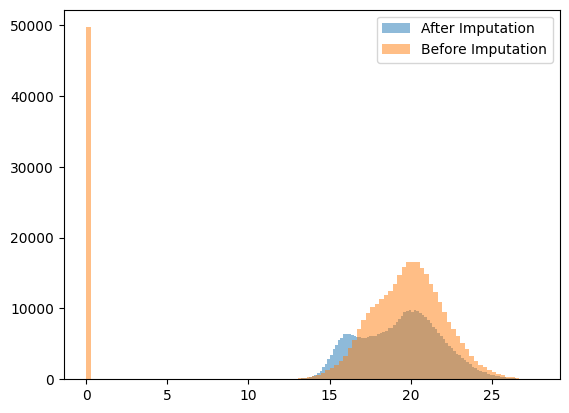

In [11]:
plt.hist(
    dc_filtered.X.flatten(), bins=100, alpha=0.5, label="After Imputation"
)  # .flatten() converts the matrix into a 1D array
plt.hist(
    dc_filtered.layers["log_intensities"].flatten(),
    bins=100,
    alpha=0.5,
    label="Before Imputation",
)
plt.legend()


### QC plotting 

#### Plotting transposed PCA to check sample clustering 
In subcellular proteomics, PCA is often performed with proteins as observations to study protein–protein relationships and subcellular structure. For quality control, however, we want to assess relationships between samples (runs/conditions/replicates).  
  
Running PCA on the transposed matrix (tPCA) treats samples as observations and proteins as features, allowing us to visualize sample-to-sample similarity and confirm that biological replicates cluster together (and that any batch effects or outliers are identifiable).

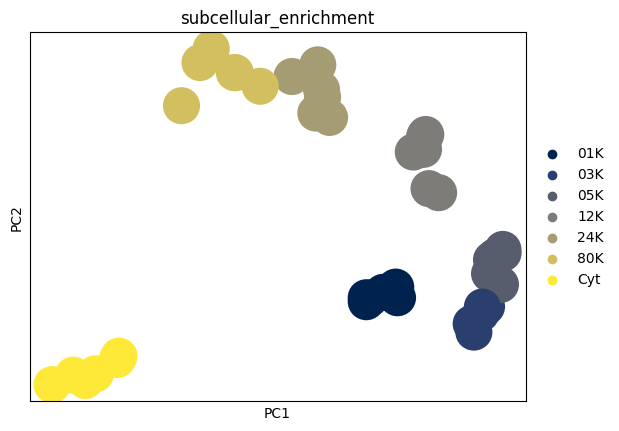

In [12]:
dc_T = dc_filtered.T.copy()
dc_T.X = dc_filtered.layers["log_intensities"].T

sc.pp.pca(dc_T)
sc.pl.pca(dc_T, color="subcellular_enrichment", palette="cividis")

#### Violin plots of Log Intensities per Sample
Plotting the distribution of protein intensities across each sample helps to identify any samples with unusual patterns or technical issues.  
As expected, the later fractions and cytosolic supernatant have fewer proteins.

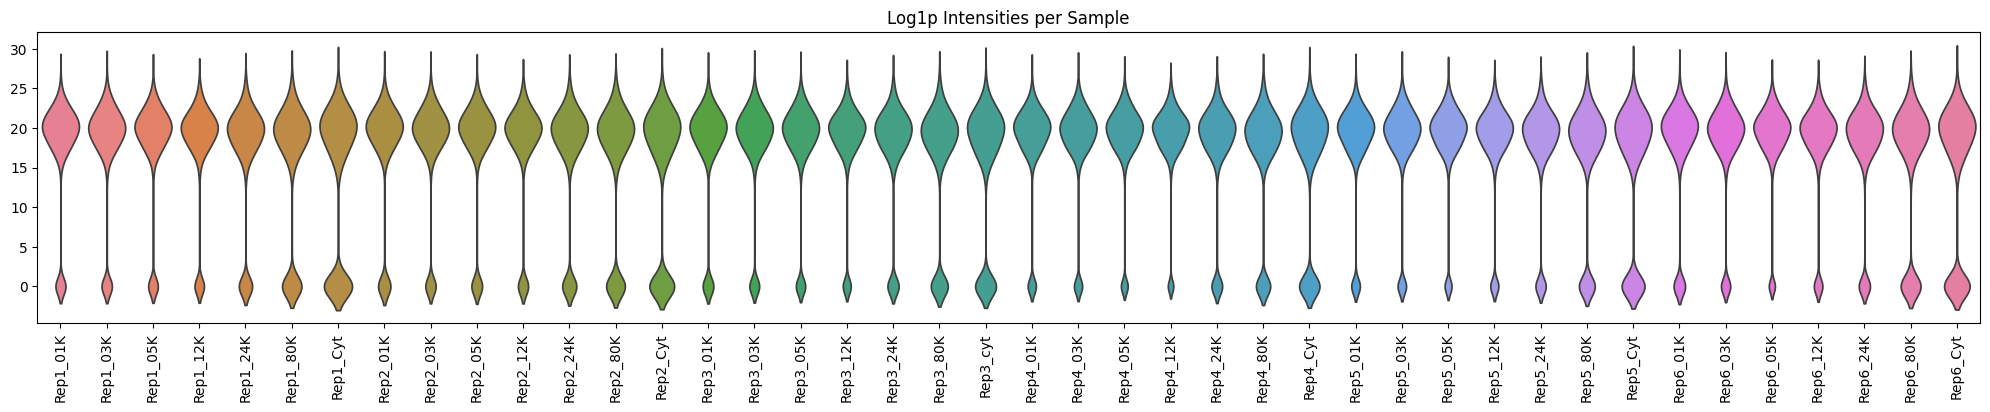

In [13]:
plot_df = dc_filtered.to_df(layer="log_intensities")

plt.figure(figsize=(20, 4))
sns.violinplot(plot_df, inner=None)
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.tight_layout()  # No fig needed
plt.title(label="Log1p Intensities per Sample")
plt.show()

#### Violin plot of QC metrics per Fraction
In addition to sample-level qc, we can examine quality control metrics at the fraction level, revealing how protein detection rates, total intensities, and dropout percentages vary across different centrifugation speeds and compartments.

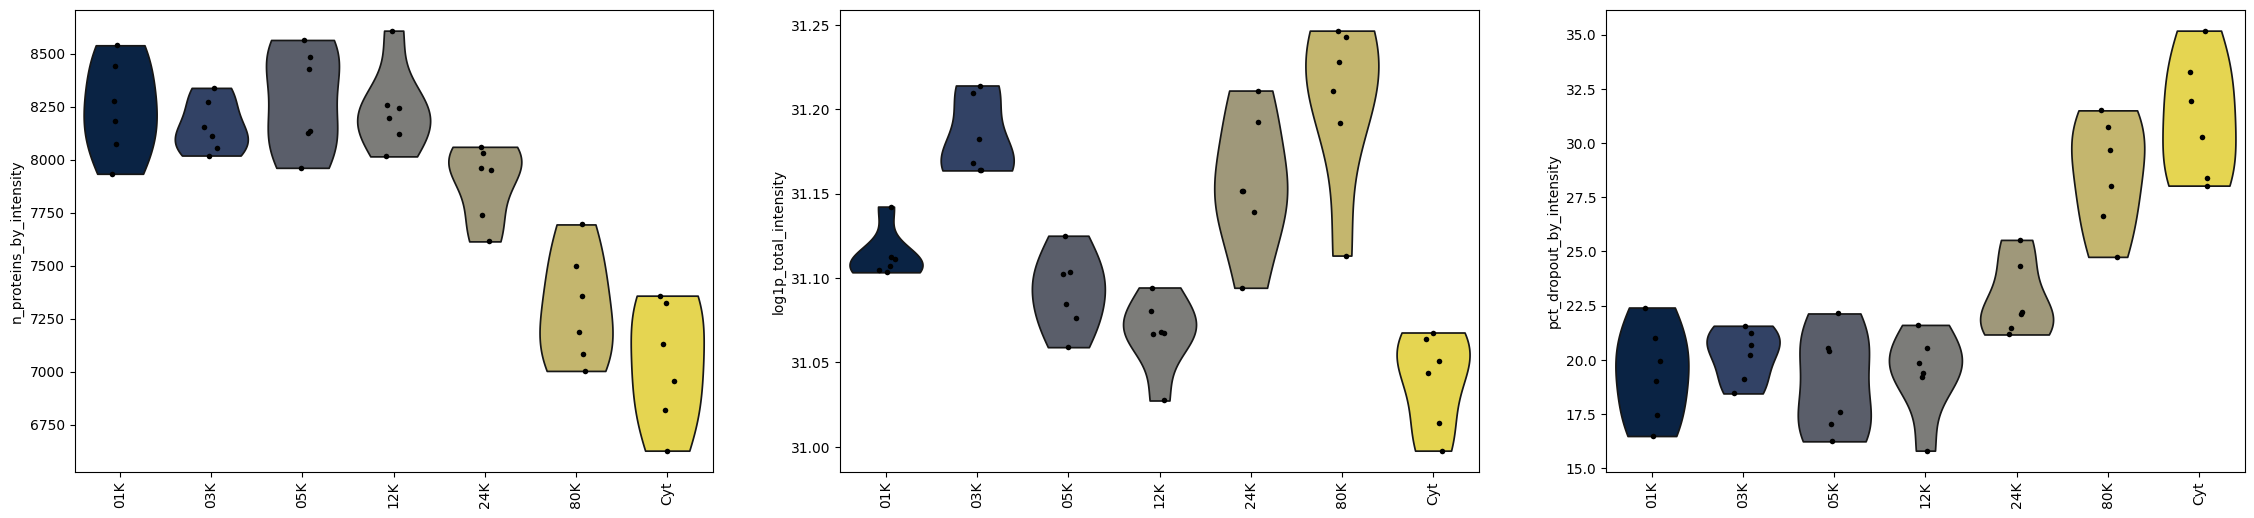

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(28, 6))
for key, ax in zip(
    ["n_proteins_by_intensity", "log1p_total_intensity", "pct_dropout_by_intensity"],
    axs,
):
    sc.pl.violin(
        dc_T,
        key,
        groupby="subcellular_enrichment",
        size=4,
        rotation=90,
        ax=ax,
        show=False,
    )

### Enrichment (Log fold change)
Grassp provides functions to calculate enrichments. Grassp enrichment function offers two enrichment calculation methods:

1. **Log fold change (lfc)** computes the difference between median intensities of the target sample versus all other samples in the same condition, providing a measure of how many times higher or lower protein levels are in the enriched fraction
2. **Proportion** calculates the relative abundance as a fraction of total intensity across target and control samples, indicating what percentage of the protein's total signal comes from the enriched condition

Here we chose the lfc transformation over proportions, because it produces a distribution of values that is closer to a normal distribution.

In [15]:
dc_filtered_enr = gr.pp.calculate_enrichment_vs_all(
    dc_filtered,
    subcellular_enrichment_column="subcellular_enrichment",
    covariates=["biological_replicate"],
    enrichment_method="lfc",
)

dc_filtered_enr = gr.pp.aggregate_samples(
    dc_filtered_enr, grouping_columns="subcellular_enrichment", agg_func=np.median
)

dc_filtered_enr

AnnData object with n_obs × n_vars = 8807 × 7
    obs: 'Protein IDs', 'Majority protein IDs', 'Peptide counts (all)', 'Peptide counts (razor+unique)', 'Peptide counts (unique)', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Q-value', 'Score', 'Intensity', 'iBAQ', 'MS/MS count', 'id', 'Peptide IDs', 'Peptide is razor', 'Mod. peptide IDs', 'Evidence IDs', 'MS/MS IDs', 'Best MS/MS', 'Oxidation (M) site IDs', 'Oxidation (M) site positions', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component', 'n_samples_by_intensity', 'mean_intensity', 'log1p_mean_intensity', 'pct_dropout_by_intensity', 'total_intensity', 'log1p_total_intensity', 'n_impute

## Dimensionality Reduction

### PCA plots 
After filtering, transformation, and computing enrichment, we can move onto visualization and interpretation!  
The following plots show how proteins cluster in reduced dimensional space based on their intensity patterns across samples, revealing groups of co-localized proteins and identifying potential subcellular localization signatures.

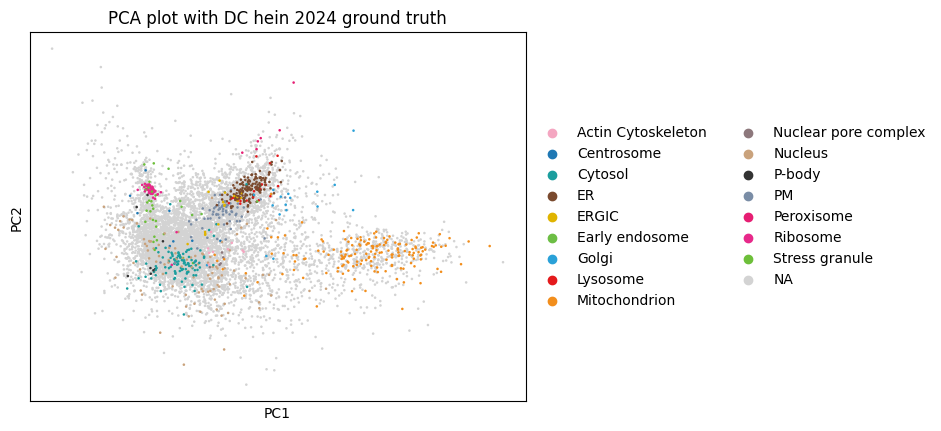

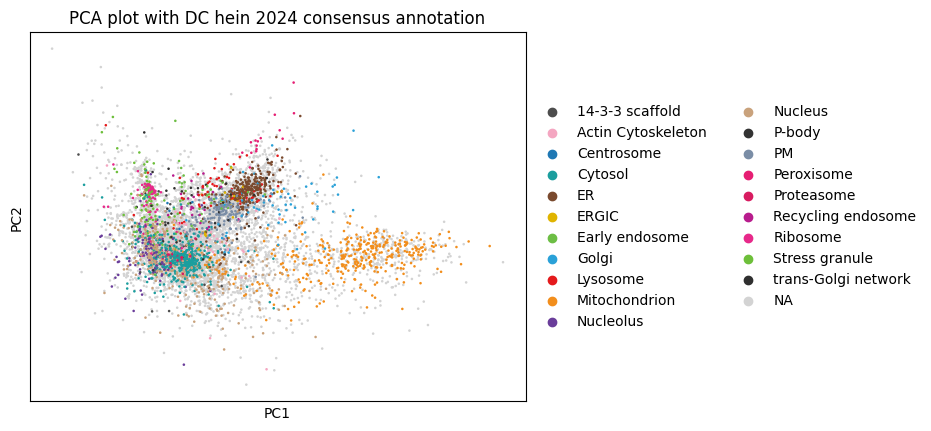

In [16]:
sc.pp.scale(dc_filtered_enr)
sc.pp.pca(dc_filtered_enr)
sc.pl.pca(
    dc_filtered_enr,
    color="hein2024_gt_component",
    title="PCA plot with DC hein 2024 ground truth",
)
sc.pl.pca(
    dc_filtered_enr, color="hein2024_component", 
    title="PCA plot with DC hein 2024 consensus annotation"
)

### UMAPs
While PCA provides a linear dimensionality reduction, UMAP offers a non-linear approach that can better preserve local neighborhood structures and reveal more complex patterns in protein localization data that might be missed by linear methods.

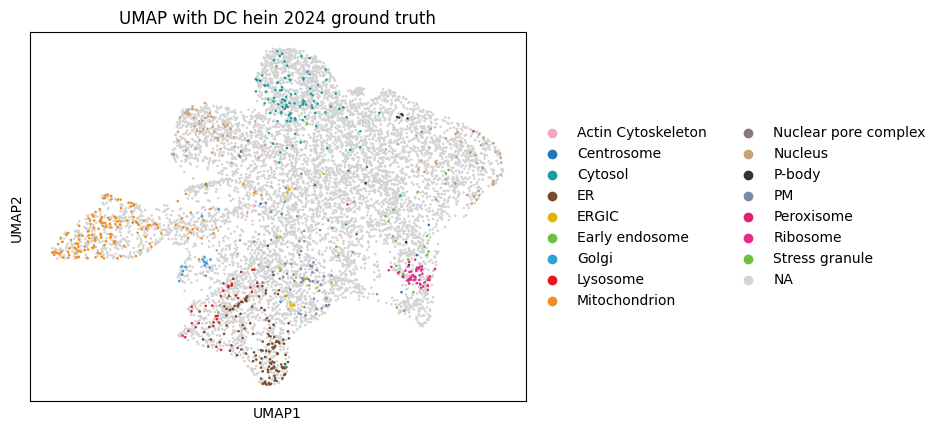

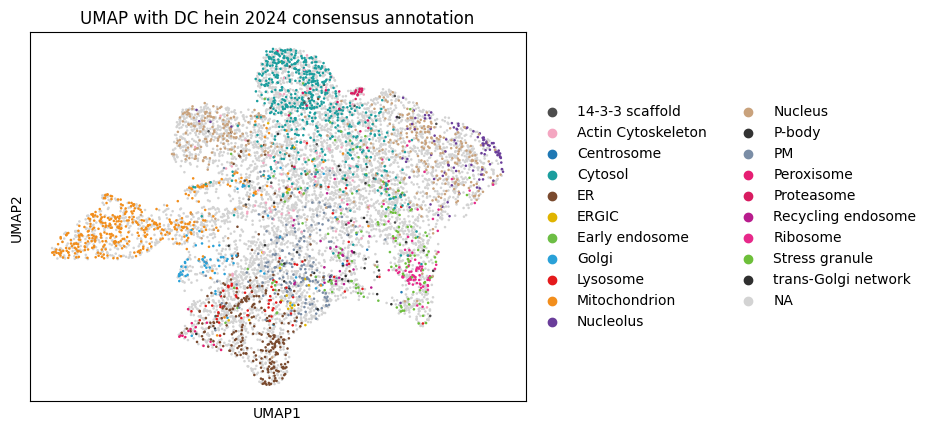

In [17]:
sc.pp.neighbors(dc_filtered_enr, use_rep="X", n_neighbors=20)
sc.tl.umap(dc_filtered_enr)
sc.pl.umap(
    dc_filtered_enr,
    color="hein2024_gt_component",
    title="UMAP with DC hein 2024 ground truth",
)
sc.pl.umap(
    dc_filtered_enr, color="hein2024_component", 
    title="UMAP with DC hein 2024 consensus annotation"
)


## Compartment Annotation

A central goal of subcellular proteomics is to infer the cellular compartment (localization) of each observed protein. One common strategy is to start from a set of marker proteins with known localization and then transfer those labels to proteins with similar subcellular profiles.

In grassp, the `knn_annotation` function implements this approach by propagating compartment labels from marker proteins to nearby proteins in the protein–protein neighbor graph

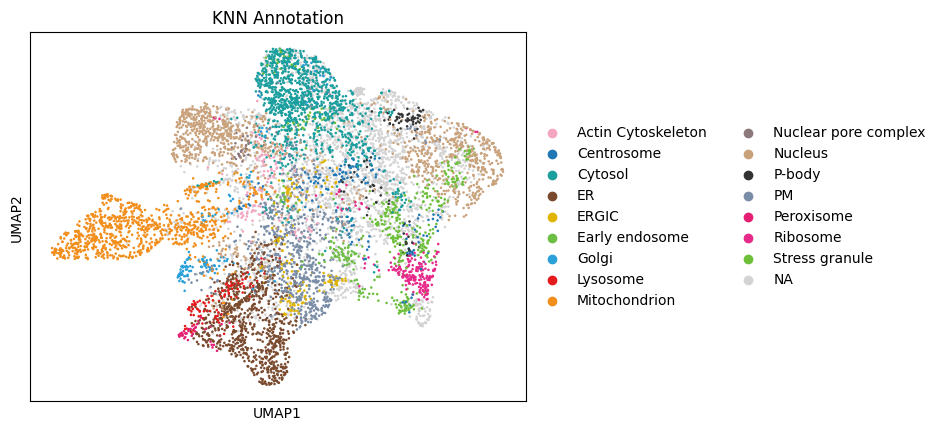

In [18]:
gr.tl.knn_annotation(
    dc_filtered_enr, gt_col="hein2024_gt_component", key_added="knn_annotation"
)

sc.pl.umap(dc_filtered_enr, color="knn_annotation", title="KNN Annotation")

After these steps, you will see that new analysis results are stored in various Anndata compartments: PCA components and UMAP coordinates are saved in .obsm, while metadata like search engine parameters and visualization settings are stored in .uns, and protein-protein relationships are captured in .obsp as distance and connectivity matrices. 

>   uns: 'Search_Engine', 'pca', 'hein2024_gt_component_colors', 'hein2024_component_colors', 'neighbors', 'umap'

>   obsm: 'X_pca', 'X_umap'

>   obsp: 'distances', 'connectivities'

In [19]:
# print the resulting Anndata object
dc_filtered_enr

AnnData object with n_obs × n_vars = 8807 × 7
    obs: 'Protein IDs', 'Majority protein IDs', 'Peptide counts (all)', 'Peptide counts (razor+unique)', 'Peptide counts (unique)', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Q-value', 'Score', 'Intensity', 'iBAQ', 'MS/MS count', 'id', 'Peptide IDs', 'Peptide is razor', 'Mod. peptide IDs', 'Evidence IDs', 'MS/MS IDs', 'Best MS/MS', 'Oxidation (M) site IDs', 'Oxidation (M) site positions', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component', 'n_samples_by_intensity', 'mean_intensity', 'log1p_mean_intensity', 'pct_dropout_by_intensity', 'total_intensity', 'log1p_total_intensity', 'n_impute